In [1]:
import matplotlib.pyplot as plt
from skimage import io, filters, util, restoration, morphology, data
import os
import numpy as np
import cv2

In [2]:
# DATA_DIR = r'D:\Researchdata\031722'
DATA_DIR = r'D:\Researchdata\ZY1'

In [19]:
def FindMask(raw_img, paras_sharp, paras_rb, paras_hys, paras_hat):
    sharpen_img = filters.unsharp_mask(raw_img, 
                                        radius = paras_sharp[0], 
                                        amount = paras_sharp[1],
                                        preserve_range = True)
    bg = restoration.rolling_ball(sharpen_img, radius = paras_rb)
    bg_reduced_img = sharpen_img - bg
    thresh = filters.threshold_otsu(bg_reduced_img)
    otsu_img = (bg_reduced_img > thresh)
    low = thresh * paras_hys
    high = thresh
    # lowt = (bg_reduced_img >= low).astype(int)
    # hight = (bg_reduced_img >= high).astype(int)
    hyst_img = filters.apply_hysteresis_threshold(bg_reduced_img, low, high).astype(int)
    footprint = morphology.disk(paras_hat)
    res = morphology.white_tophat(hyst_img, footprint)
    res_img = hyst_img - res.astype(int)

    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 15))
    ax[0, 0].imshow(raw_img, cmap = 'gray')
    ax[0, 0].set_title('Raw')
    ax[0, 1].imshow(sharpen_img, cmap = 'gray')
    ax[0, 1].set_title('Sharpened')
    ax[0, 2].imshow(bg_reduced_img, cmap = 'gray')
    ax[0, 2].set_title('BG reduced')
    ax[1, 0].imshow(otsu_img, cmap = 'gray')
    ax[1, 0].set_title('OTSU')
    ax[1, 1].imshow(hyst_img, cmap = 'gray')
    ax[1, 1].set_title('Hysteresis')
    ax[1, 2].imshow(res_img, cmap = 'gray')
    ax[1, 2].set_title('Tophat')

    for a in ax.ravel():
        a.axis('off')
    
    plt.tight_layout()
    plt.show()

In [21]:
for parent, dir, file in os.walk(DATA_DIR):
    if( 'tiff' in parent):
        for f in file:
            raw_stack = io.imread(os.path.join(parent, f))
            break
            for i in range(raw_stack.shape[0]):
                raw_img = raw_stack[i, ..., 2]
                FindMask(raw_img, [10, 2], 55, .95, 1)
                break


C:\Users\littl\anaconda3\envs\pilus\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


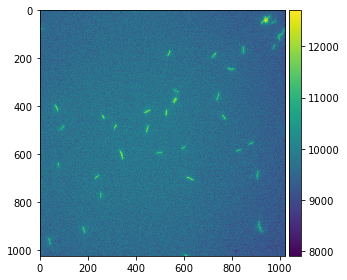

In [11]:
io.imshow(raw_img)

Sharpen

In [222]:
raw_img = raw_stack[20, ...,2]
img = filters.unsharp_mask(raw_img, radius=10, amount=2, preserve_range=True)
# io.imshow(img, cmap = 'gray')

Reduce BG

In [231]:
background = restoration.rolling_ball(img, radius = 50)
# io.imshow(reduce_bg_img, cmap = 'gray')

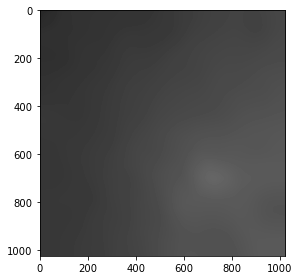

In [232]:
footprint = morphology.disk(60)
normal_background = util.img_as_int(filters.rank.mean(util.img_as_int(background.astype(int)), selem=footprint))
io.imshow(normal_background)

In [233]:
reduce_bg_img = img - normal_background

Segmentation

In [234]:
# thresh = filters.threshold_otsu(reduce_bg_img)
# binary = reduce_bg_img > thresh
# io.imshow(np.int0(binary), cmap = 'gray')

In [235]:
thresholds = filters.threshold_multiotsu(reduce_bg_img, classes=4)

# Using the threshold values, we generate the three regions.
regions = np.digitize(reduce_bg_img, bins=thresholds)

# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# # Plotting the original image.
# ax[0].imshow(reduce_bg_img, cmap='gray')
# ax[0].set_title('Original')
# ax[0].axis('off')

# # Plotting the histogram and the two thresholds obtained from
# # multi-Otsu.
# ax[1].hist(reduce_bg_img.ravel(), bins=255)
# ax[1].set_title('Histogram')
# for thresh in thresholds:
#     ax[1].axvline(thresh, color='r')

# # Plotting the Multi Otsu result.
# ax[2].imshow(regions, cmap='jet')
# ax[2].set_title('Multi-Otsu result')
# ax[2].axis('off')

# plt.subplots_adjust()

# plt.show()

thresh = [thr for thr in thresholds if thr > 3000][0]

Hysteresis - Dilate

In [239]:
# image = data.coins()
# edges = filters.sobel(image)

low = thresh * .8
high = thresh

lowt = (reduce_bg_img > low).astype(int)
hight = (reduce_bg_img > high).astype(int)
hyst = filters.apply_hysteresis_threshold(reduce_bg_img, low, high)
hyst_img = np.logical_or(hyst, hight)
# io.imshow(np.int0(binary), cmap = 'gray')

White tophat - erode

In [240]:
footprint = morphology.disk(1)
res = morphology.white_tophat(hyst_img, footprint)
# res = morphology.white_tophat(binary, footprint)
# io.imshow(binary - np.int0(res), cmap = 'gray')

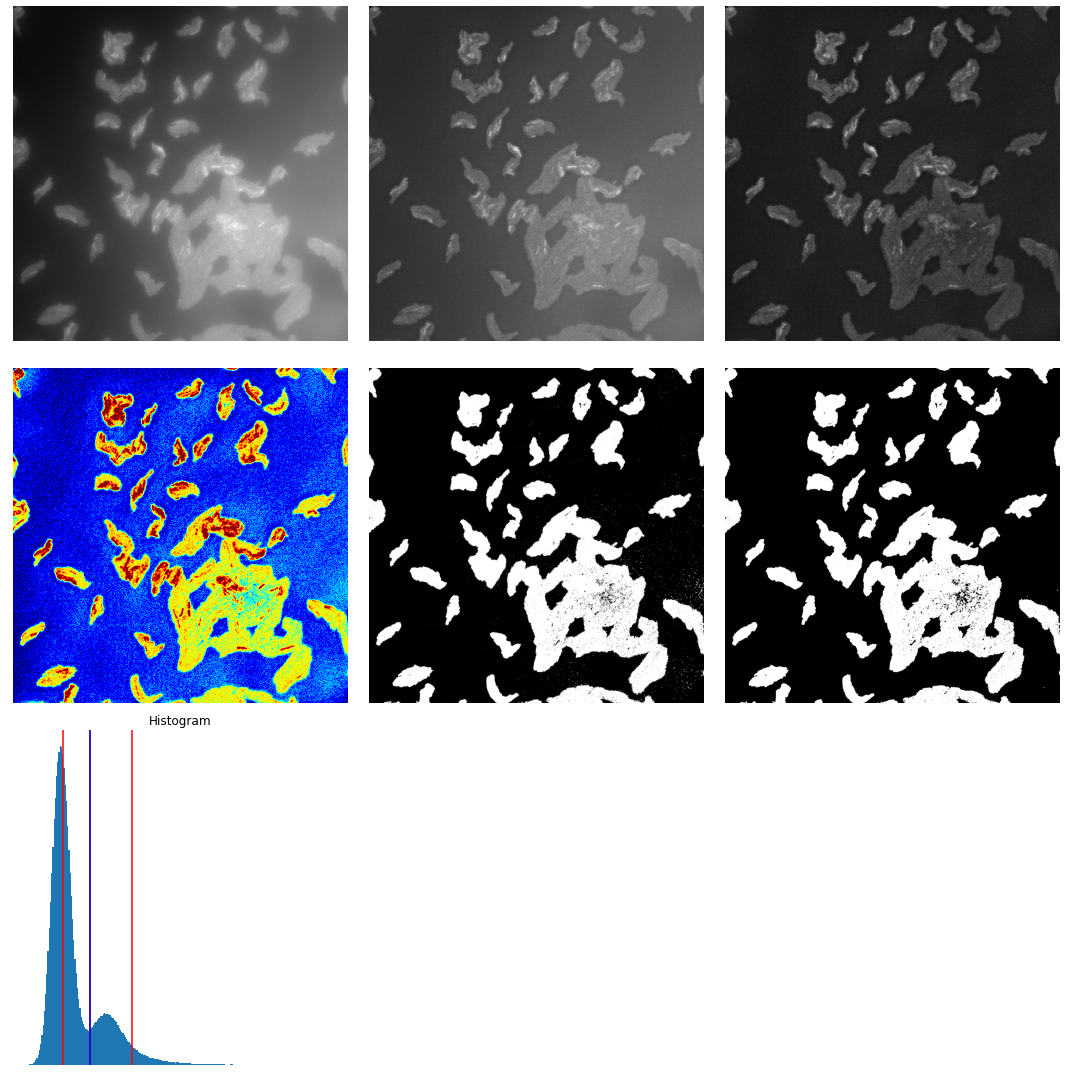

In [241]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))

ax[0, 0].imshow(raw_img, cmap = 'gray')
ax[0, 1].imshow(img, cmap = 'gray')
ax[0, 2].imshow(reduce_bg_img, cmap = 'gray')
ax[1, 0].imshow(regions, cmap = 'jet')
ax[1, 1].imshow(hyst_img, cmap = 'gray')
ax[1, 2].imshow(hyst_img - np.int0(res), cmap = 'gray')
ax[2, 0].hist(reduce_bg_img.ravel(), bins=256)
ax[2, 0].set_title('Histogram')
for thr in thresholds:
    ax[2, 0].axvline(thr, color='r')
ax[2, 0].axvline(thresh, color = 'b')
# ax[2, 0].axvline(thresh, color='r')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()

plt.show()